# LAB: Regresión Logística: Haciendo predicciones sobre datos de cáncer de mama

## 1. Introducción

Este dataset sobre cáncer de mama se obtuvo del Hospital de la Universidad de Wisconsin. Son datos producidos por el Dr. William Wolberg en la década del '90. Contiene información de estudios clínicos y celulares. El objetivo es predecir el carácter benigno ($class_t=0$) maligno ($class_t=1$) del cáncer en función de una serie de predictores a nivel celular.


* class_t es la variable target

* el resto son variables con valores normalizados de 1 a 10


[Aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names) pueden encontrar más información sobre el dataset.

**Nota:** se eliminaron del dataset original 16 casos con valores perdidos en algunos campos.

In [1]:
### Importar los paquetes a usar
%pylab inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/home/digitalhouse/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
### Importamos los datos

df = pd.read_csv('./Data/breast-cancer.csv', header = None)
df.columns = ['ID', 'clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion', 'epith_cell_Size', 'bare_nuclei',
              'bland_chromatin ','norm_nucleoli', 'mitoses', 'class_t']
df.sample(10)

,ID,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
262,390840,8,4,7,1,3,10,3,9,2,4
653,1350423,5,10,10,8,5,5,7,10,1,4
513,807657,6,1,3,2,2,1,1,1,1,2
35,1080185,10,10,10,8,6,1,8,9,1,4
616,1238777,1,1,1,1,2,1,1,1,1,2
90,1157734,4,1,1,1,2,1,3,1,1,2
398,1238915,5,1,2,1,2,1,3,1,1,2
140,1184184,1,1,1,1,2,5,1,1,1,2
458,1269574,4,1,1,1,2,1,1,1,1,2
37,1084584,5,4,4,9,2,10,5,6,1,4


In [5]:
df.class_t[df['class_t'] == 2] = 0
df.class_t[df['class_t'] == 4] = 1

## 2. Análisis Exploratorio de los Datos

Realizar un análisis descriptivo y exploratorio de los datos.

In [6]:
df.iloc[:,1:len(df)].describe()

,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


¿Qué variables están más correlacionadas entre sí y con la variable dependiente?

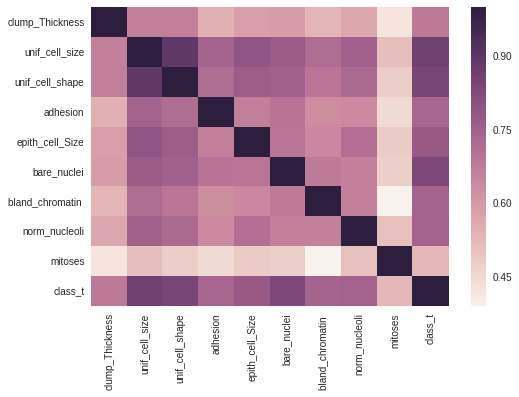

In [7]:
sns.heatmap(df.corr(method = 'spearman').iloc[1:len(df),1:len(df)]);

## 3. Fiteando un modelo de regresión logística

Dividimos el target y $X$

In [8]:
X = df.iloc[:,1:9]

In [9]:
y = df['class_t']

### 3.1 Usando `scikit-learn`

Vamos a evaluar un modelo usando validación cruzada. La idea es estimar el test error usando validación cruzada en lugar de la partición clásica entre test y train.

La idea es poder guardar mucha información de los modelos estimados.

1. las predicicones de las k iteraciones que realicen
2. los coeficientes de los k modelos estimados
3. los scores de los k modelos estimados
4. las matrices de confusión de los k modelos estimados

**Hint:** traten de usar el iterador [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) del módulo `sklearn.model_selection`.

- Lo que devuelve el método `KFold` es un array de índices con las $k$ particiones entre train y test.

- Luego, pueden usar esos índices para hacer subsetting del dataframe

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix 

kf = KFold(n_splits=10, random_state=None, shuffle=True)

logit = LogisticRegression()

kf_y_preds = []
kf_model = []
kf_coefs = []
kf_scores = []
kf_matrix = []

for k, (train_index, test_index) in enumerate(kf.split(X)):
    model = logit.fit(X.iloc[train_index], y[train_index])
    kf_model.append(model)
    coefs = model.coef_
    y_preds = model.predict(X.iloc[test_index])
    kf_y_preds.append(y_preds)
    kf_coefs.append(coefs)
    scores = accuracy_score(y[test_index],y_preds)
    kf_scores.append(scores)
    matrix = confusion_matrix(y[test_index],y_preds)
    kf_matrix.append(matrix)
    print("K",k," = ", scores, sep="")   

K0 = 0.985507246377
K1 = 0.95652173913
K2 = 0.971014492754
K3 = 0.985294117647
K4 = 0.926470588235
K5 = 0.970588235294
K6 = 0.970588235294
K7 = 0.941176470588
K8 = 0.970588235294
K9 = 0.985294117647


* ¿Cuál es la performance de este modelo?

In [11]:
np.mean(kf_scores)

0.9663043478260871

### 3.2 Usando  `statsmodels`

Hagamos, ahora, la partición tradicional entre train y test. Primero, agregamos el intercepto (porque `statsmodels` no lo agrega por default).

In [13]:
X = sm.tools.add_constant(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Estimemos una regresión logística usando `statsmodels`.

In [15]:
logit = sm.Logit(y_train, X_train)

result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.076798
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.880      
Dependent Variable: class_t          AIC:              96.6410    
Date:               2017-09-28 17:32 BIC:              134.7859   
No. Observations:   512              Log-Likelihood:   -39.320    
Df Model:           8                LL-Null:          -327.49    
Df Residuals:       503              LLR p-value:      2.8539e-119
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------
const             -9.5466   1.2498 -7.6386 0.0000 -11.9961 -7.0971
clump_Thickness    0.5025   0.1495  3.3605 0.0008   0

Obtengamos la matriz de clasificación en el test set.

In [16]:
y_pred = result.predict(X_test) > 0.5
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[102,   3],
       [  4,  62]])

¿Cómo funciona el modelo en el test set?

In [17]:
np.sum(y_test == y_pred)/len(y_test)

0.95906432748538006

### 3.2 Usando (de nuevo) `sklearn`

Repliquemos, ahora el ejercicio con `sklearn`. 

** ADVERTENCIA **

Recuerden dropear la primera columna de `X_train` y `X_test` (porque agregamos un intercepto). Y, además, dado que `LogisticRegression` aplica un parámetro de regularización por defecto es importante setear el parámetro de la siguiente forma `C=1e10` (es decir, en valores altos).

In [18]:
X_test = X_test.drop('const', axis=1)
X_train = X_train.drop('const', axis=1)

In [19]:
reglogsklearn = LogisticRegression(fit_intercept=True,penalty='l2',C = 1e10)
reglogsklearn.fit(X_train, y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [20]:
reglogsklearn.intercept_, reglogsklearn.coef_

(array([-9.5458202]),
 array([[ 0.50241727,  0.09030841,  0.24896675,  0.19935251,  0.31142826,
          0.46768268,  0.37826181,  0.13452331]]))

In [21]:
y_pred2 = reglogsklearn.predict(X_test)
accuracy_score(y_test, y_pred2)

0.95906432748538006

In [22]:
confusion_matrix(y_test, y_pred2)

array([[102,   3],
       [  4,  62]])

## 4. Análisis e interpretación

* ¿Qué pueden decir de este modelo?
* ¿Cómo funciona el ajuste del mismo?
* ¿Cuáles son las principales variables predictoras del tipo de tumor?

## 5. Comparación con KNN

Con el mismo split entre train y test que generaron anteriormente, utilizar el conjunto de train para estimar un modelo de KNN con hiperparámetros óptimos y comparar la performance sobre datos no observados con respecto a la regresión logística. 

In [19]:
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def scores_knn(X,y,start,stop,step):
    
    # Voy a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto voy a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    # Lista de Diccionarios
    
    scores_para_df = []
    
    # range(1,40,5) son los posibles valores de n_neighbors que quiero explorar. Son todos los enteros desde el 1
    # hasta el 40 en saltos de a 5. (Start,Stop,Step)
    
    for i in range(start,stop,step):
        # En cada iteración instanciamos el modelo con un hiperparámetro distinto
        
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV  
        
        kf = KFold(n_splits=10, shuffle=True)
        
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
        
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardo cada uno en la lista de diccionarios
        
        scores_para_df.append(dict_row_score)
        
    df_scores = pd.DataFrame(scores_para_df)
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    return df_scores

In [34]:
from sklearn import preprocessing

X_train_std = preprocessing.scale(X_train, axis = 0)
df_scores = scores_knn(X_train_std,y_train,1,20,1)

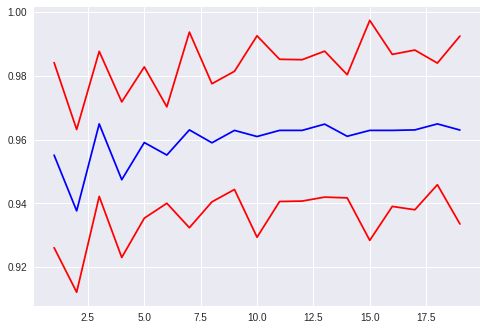

In [35]:
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');

In [37]:
# EL número de vecinos óptimo es 3

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)


In [40]:
np.std(X_train_std[:,1])

0.99999999999999989

In [41]:
model = KNeighborsClassifier(n_neighbors=3)

In [43]:
model.fit(X_train_std,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [44]:
X_test_std = scaler.transform(X_test)

In [45]:
y_pred = model.predict(X_test_std)

In [47]:
accuracy_score(y_test, y_pred)

0.96491228070175439